<a href="https://colab.research.google.com/github/ehas1/Statistical-Bias-in-ML/blob/main/OAIP_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import pandas as pd
import requests
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss
from graphviz import Digraph
from joblib import dump, load
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
# define functions

def load_data(
    url: str = "https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/cox-violent-parsed.csv"
    ) -> pd.DataFrame:
    """Download COMPAS data set from Github to current directory. (Add a copy of
    the file to your repository and download it from there.) Then load file into
    RAM."""

    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))

    return data

def preprocess_data(data: pd.DataFrame, random_state: int = 42) -> tuple:
    """Preprocess COMPAS data set. Include feature grabbing, string parsing, 1-hot
    encoding, train-test split and feature normalization."""

       # Remove invalid recidivism records and select features
    data = data[data['is_recid'] != -1]
    features = ["sex", "age", "race", "juv_fel_count", "juv_misd_count",
                "juv_other_count", "priors_count", "c_charge_degree"]
    X = data[features].copy()  # Create an explicit copy
    y = data['is_recid']

    # Categorize charge degree
    X.loc[:, 'c_charge_degree'] = X['c_charge_degree'].fillna('Other')
    X.loc[:, 'c_charge_degree'] = X['c_charge_degree'].apply(
        lambda x: 'Felony' if str(x).startswith('F') else
                 'Misdemeanor' if str(x).startswith('M') else 'Other'
    )

    # One-hot encode categorical features
    X_encoded = pd.get_dummies(X, columns=['sex', 'race', 'c_charge_degree'])

    # Normalize numerical features
    numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
    for col in numerical_features:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,
                                                        random_state=random_state)

    return [X_train, y_train], [X_test, y_test]


def train_model(train_data: list, model_type: str = 'decision_tree', params: dict = None):
    """Train either a decision tree or XGBoost model on the training data.

    Args:
        train_data: List containing [X_train, y_train]
        model_type: Either 'decision_tree' or 'xgboost'
        params: Dictionary of model parameters
    """
    X_train, y_train = train_data
    if params is None:
        params = {}

    if model_type == 'decision_tree':
        model = DecisionTreeClassifier(**params)
    elif model_type == 'xgboost':
        model = xgb.XGBClassifier(**params)
    else:
        raise ValueError("model_type must be either 'decision_tree' or 'xgboost'")

    model.fit(X_train, y_train)
    return model

def train_with_crossvalidation(train_data: list, model_type: str = 'decision_tree',
  n_fold: int = 5, params: dict = None, shuffle=True, random_state=42) -> dict:
  """Split training data into folds, train and evaluate model on each fold."""

  X_train, y_train = train_data
  kf = KFold(n_splits=n_fold, shuffle=shuffle, random_state=random_state)
  models = ["" for i in range(n_fold)]
  cv_evals = ["" for i in range(n_fold)]

  for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data using indices
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model on this fold
    model = train_model([X_train_fold, y_train_fold], model_type=model_type, params=params)
    models[i] = model

    # Evaluate on train and validation sets
    cv_evals[i] = {
        "train_evals": test_model(model, [X_train_fold, y_train_fold]),
        "validation_evals": test_model(model, [X_val_fold, y_val_fold])
    }

  return cv_evals

def optimize_depth(train_data: list, model_type: str = 'decision_tree',
                  min_td: int = 2, max_td: int = 6,
                  n_fold: int = 5, params: dict = None, overfitting_penalty: float = 0.3) -> tuple:
  """Perform crossvalidated training pipeline for several values of tree_depth."""

  optimization_evals = {}
  depth_analysis = {}

  for tree_depth in range(min_td, max_td+1):
    if params is None:
        params = {}
    params['max_depth'] = tree_depth
    cv_evals = train_with_crossvalidation(train_data,
      model_type=model_type, n_fold=n_fold, params=params)
    optimization_evals[tree_depth] = cv_evals

    # Calculate metrics for this depth
    val_acc = np.mean([fold['validation_evals']['accuracy'] for fold in cv_evals])
    val_std = np.std([fold['validation_evals']['accuracy'] for fold in cv_evals])
    train_acc = np.mean([fold['train_evals']['accuracy'] for fold in cv_evals])
    overfitting_gap = train_acc - val_acc

    depth_analysis[tree_depth] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_std': val_std,
        'overfitting_gap': overfitting_gap
    }

  # Select best depth based on validation accuracy and overfitting gap
  best_depth = max(depth_analysis.keys(),
                  key=lambda d: depth_analysis[d]['val_acc'] - 0.5 * depth_analysis[d]['overfitting_gap'])

  # Calculate overall accuracy as mean of all validation accuracies across all folds
  overall_accuracies = []
  for fold in optimization_evals[best_depth]:
      overall_accuracies.append(fold['validation_evals']['accuracy'])
  overall_accuracy = np.mean(overall_accuracies)

  print(f"\nBest depth: {best_depth}")
  print(f"Overall Accuracy: {overall_accuracy:.1%}")
  print(f"Validation Accuracy: {depth_analysis[best_depth]['val_acc']:.3f}")
  print(f"Overfitting Gap: {depth_analysis[best_depth]['overfitting_gap']:.3f}")

  return optimization_evals, best_depth, depth_analysis

def tree_viz(model: object) -> plt.figure:
    """Create a visualization of a decision tree."""
    # Create directed graph
    fig = Digraph(comment='Decision Tree Visualization')
    fig.attr(rankdir='TB')  # Top to bottom layout

    # Set visualization style
    fig.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
    fig.attr('edge', color='gray50')
    fig.attr(bgcolor='white')

    # Get tree structure
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    # Create nodes with simplified information
    for node_id in range(n_nodes):
        if children_left[node_id] == -1:  # Leaf node
            prob = value[node_id][0, 1] / value[node_id].sum()
            color = 'lightpink' if prob >= 0.5 else 'lightgreen'
            label = f'Prediction: {"Yes" if prob >= 0.5 else "No"}'
            fig.node(str(node_id), label, fillcolor=color)
        else:  # Decision node
            feat_name = model.feature_names_in_[feature[node_id]]
            split_value = threshold[node_id]

            # Format the split value based on feature type
            if feat_name in ['sex_Female', 'sex_Male'] or feat_name.startswith('race_') or feat_name.startswith('c_charge_degree_'):
                # For one-hot encoded features, show as is (0 or 1)
                label = f'{feat_name}\n= {int(split_value)}'
            else:
                # For numerical features, show as integers if they're counts
                if feat_name in ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
                    label = f'{feat_name}\n≤ {int(round(split_value))}'
                else:  # For age, keep one decimal place
                    label = f'{feat_name}\n≤ {int(round(split_value * 100))}'

            fig.node(str(node_id), label)

            # Add edges to children with Yes/No labels
            fig.edge(str(node_id), str(children_left[node_id]), 'Yes')
            fig.edge(str(node_id), str(children_right[node_id]), 'No')

    # Set graph size and font
    fig.attr(size='12,12')
    fig.attr(fontsize='10')

    return fig


def test_model(model: DecisionTreeClassifier, data: list) -> dict:
    """Test a given model (is it a classifier or a regressor?). Include all
    metrics that you want to use in later analyses. This may include accuracy,
    loss, TPR, FPR, etc. Return them as a dictionary."""

    X_test, y_test = data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    evals = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),  # Same as TPR
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'loss': log_loss(y_test, y_prob),
        'tpr': tp / (tp + fn),  # True Positive Rate
        'fpr': fp / (fp + tn),  # False Positive Rate
        'tnr': tn / (tn + fp),  # True Negative Rate
        'fnr': fn / (fn + tp),  # False Negative Rate
    }

    return evals


def plot_evals(evals: dict) -> plt.figure:
    """Show training and test accuracy as a function of number of epochs. Includes other metrics"""

    # Set style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 4)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Plot 1: Accuracy metrics
    metrics1 = ['accuracy', 'precision', 'recall', 'f1']
    values1 = [evals[m] for m in metrics1]
    sns.barplot(x=metrics1, y=values1, ax=ax1)
    ax1.set_title('Accuracy Metrics')
    ax1.set_ylim(0, 1)

    # Plot 2: Error rates
    metrics2 = ['tpr', 'fpr', 'tnr', 'fnr']
    values2 = [evals[m] for m in metrics2]
    sns.barplot(x=metrics2, y=values2, ax=ax2)
    ax2.set_title('Error Rates')
    ax2.set_ylim(0, 1)

    # Plot 3: ROC-AUC and Loss
    metrics3 = ['roc_auc', 'loss']
    values3 = [evals[m] for m in metrics3]
    sns.barplot(x=metrics3, y=values3, ax=ax3)
    ax3.set_title('ROC-AUC & Loss')

    # Adjust layout
    plt.tight_layout()

    return fig


def plot_cv_evals(cv_evals: list) -> plt.figure:
    """Show training and test accuracy as a function of number of epochs. Instead
    of showing 5 separate plots for 5-fold crossvalidation, just show the mean as
    a line in the foreground and the envelope from min to max as a shaded area"""

    # Set style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (10, 6)

    # Extract metrics from all folds
    train_metrics = []
    val_metrics = []
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']

    for fold in cv_evals:
        train_metrics.append([fold['train_evals'][metric] for metric in metrics_to_plot])
        val_metrics.append([fold['validation_evals'][metric] for metric in metrics_to_plot])

    # Convert to numpy arrays for easier computation
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)

    # Create figure
    cv_fig, ax = plt.subplots()
    x = np.arange(len(metrics_to_plot))

    # Plot training metrics
    ax.plot(x, train_metrics.mean(axis=0), 'b-', label='Train (mean)', linewidth=2)
    ax.fill_between(x, train_metrics.min(axis=0), train_metrics.max(axis=0),
                   alpha=0.2, color='blue', label='Train (min-max)')

    # Plot validation metrics
    ax.plot(x, val_metrics.mean(axis=0), 'r-', label='Validation (mean)', linewidth=2)
    ax.fill_between(x, val_metrics.min(axis=0), val_metrics.max(axis=0),
                   alpha=0.2, color='red', label='Validation (min-max)')

    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.set_title('Cross-validation Performance Metrics')
    ax.legend(loc='lower right')
    plt.tight_layout()

    return cv_fig


def plot_optimization_evals(evals: list) -> plt.figure:
    """Create plots that show test and validation accuracy as a function of tree
     depth. Show results for different numbers of epochs as different lines."""
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (10, 6)

    # Initialize lists to store metrics
    tree_depths = []
    train_accuracies = []
    train_accuracies_min = []
    train_accuracies_max = []
    val_accuracies = []
    val_accuracies_min = []
    val_accuracies_max = []

    # Extract metrics for each tree depth
    for depth, cv_evals in evals.items():
        tree_depths.append(depth)

        # Get training accuracies across folds
        train_acc = [fold['train_evals']['accuracy'] for fold in cv_evals]
        train_accuracies.append(np.mean(train_acc))
        train_accuracies_min.append(np.min(train_acc))
        train_accuracies_max.append(np.max(train_acc))

        # Get validation accuracies across folds
        val_acc = [fold['validation_evals']['accuracy'] for fold in cv_evals]
        val_accuracies.append(np.mean(val_acc))
        val_accuracies_min.append(np.min(val_acc))
        val_accuracies_max.append(np.max(val_acc))

    opt_fig, ax = plt.subplots()

    # Plot training metrics
    ax.plot(tree_depths, train_accuracies, 'b-', label='Train (mean)', linewidth=2)
    ax.fill_between(tree_depths, train_accuracies_min, train_accuracies_max,
                   alpha=0.2, color='blue', label='Train (min-max)')

    # Plot validation metrics
    ax.plot(tree_depths, val_accuracies, 'r-', label='Validation (mean)', linewidth=2)
    ax.fill_between(tree_depths, val_accuracies_min, val_accuracies_max,
                   alpha=0.2, color='red', label='Validation (min-max)')

    ax.set_xlabel('Tree Depth')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance vs Tree Depth')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Set axis limits
    ax.set_ylim(0, 1)
    ax.set_xticks(tree_depths)

    plt.tight_layout()

    return opt_fig


def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.02), input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train_neural_network(train_data, validation_data=None, epochs=100):
    X_train, y_train = train_data

    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )

    callbacks = [early_stopping, reduce_lr]

    # Create and train model
    model = create_model(input_dim=X_train.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2 if validation_data is None else 0,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1
    )

    # Print training summary
    print("\nTraining Summary:")
    print(f"Total epochs trained: {len(history.history['loss'])}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.2%}")
    if 'val_accuracy' in history.history:
        print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.2%}")
    if 'auc' in history.history:
        print(f"Final training AUC: {history.history['auc'][-1]:.4f}")

    return model, history

def train_with_crossvalidation_nn(train_data, n_fold=5, random_state=42):
    X_train, y_train = train_data
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    cv_evals = []

    # Lists to store metrics across folds
    accuracies = []
    balanced_accuracies = []
    roc_aucs = []
    f1_scores = []
    mccs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\nFold {fold + 1}/{n_fold}")

        # Split data
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # Train model
        model, history = train_neural_network(
            [X_train_fold, y_train_fold],
            validation_data=(X_val_fold, y_val_fold)
        )

        # Evaluate
        train_evals = test_model_nn(model, [X_train_fold, y_train_fold])
        val_evals = test_model_nn(model, [X_val_fold, y_val_fold])

        # Store validation metrics
        accuracies.append(val_evals['accuracy'])
        balanced_accuracies.append(val_evals['balanced_accuracy'])
        roc_aucs.append(val_evals['roc_auc'])
        f1_scores.append(val_evals['f1'])
        mccs.append(val_evals['mcc'])
        cv_evals.append({
            "train_evals": train_evals,
            "validation_evals": val_evals,
            "history": history.history
        })

        # Clear session to free memory
        tf.keras.backend.clear_session()

        # Print cross-validation summary
    print("\nCross-validation Summary:")
    print(f"Mean Accuracy: {np.mean(accuracies):.2%} (±{np.std(accuracies):.2%})")
    print(f"Mean Balanced Accuracy: {np.mean(balanced_accuracies):.2%} (±{np.std(balanced_accuracies):.2%})")
    print(f"Mean ROC AUC: {np.mean(roc_aucs):.4f} (±{np.std(roc_aucs):.4f})")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
    print(f"Mean Matthews Correlation Coefficient: {np.mean(mccs):.4f} (±{np.std(mccs):.4f})")

    return cv_evals

def test_model_nn(model, data, print_metrics=True):
    """Evaluate neural network performance with comprehensive metrics."""
    X_test, y_test = data
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_prob = model.predict(X_test)

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    loss = log_loss(y_test, y_prob)
    tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity)
    fpr = fp / (fp + tn)  # False Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fnr = fn / (fn + tp)  # False Negative Rate

    # Calculate additional metrics
    balanced_accuracy = (tpr + tnr) / 2
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + 1e-8)  # Matthews Correlation Coefficient

    evals = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'mcc': mcc,
        'loss': loss,
        'tpr': tpr,
        'fpr': fpr,
        'tnr': tnr,
        'fnr': fnr,
    }

    if print_metrics:
        print("\nModel Evaluation Metrics:")
        print(f"Overall Accuracy: {accuracy:.2%}")
        print(f"Balanced Accuracy: {balanced_accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall (Sensitivity): {recall:.2%}")
        print(f"Specificity: {tnr:.2%}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Matthews Correlation Coefficient: {mcc:.4f}")
        print(f"Log Loss: {loss:.4f}")
        print("\nConfusion Matrix Metrics:")
        print(f"True Positives: {tp}")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")

    return evals

In [3]:
# DATA

data = load_data()
train_data, test_data = preprocess_data(data)


Best depth: 5
Overall Accuracy: 66.0%
Validation Accuracy: 0.660
Overfitting Gap: 0.001


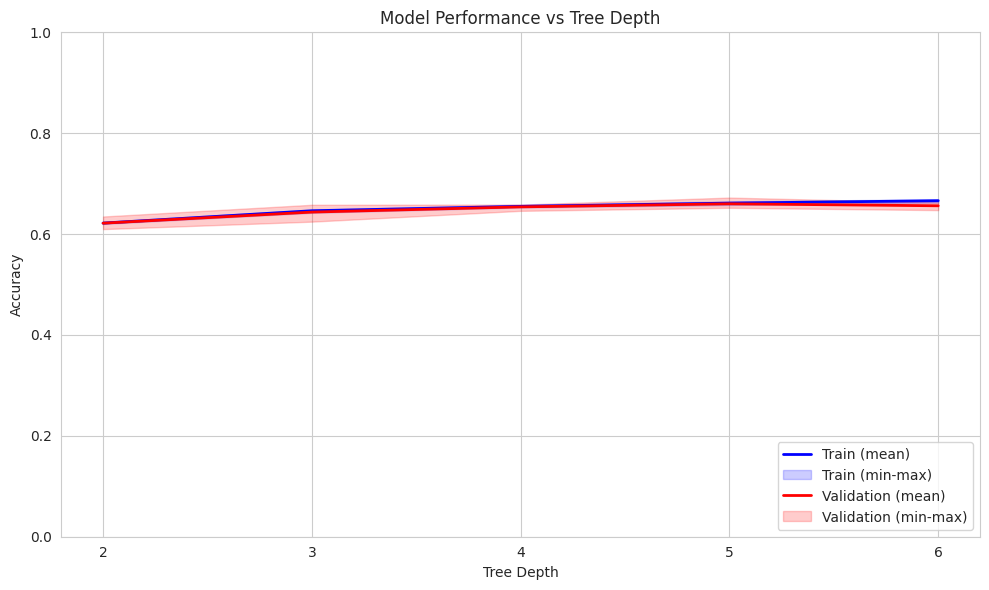

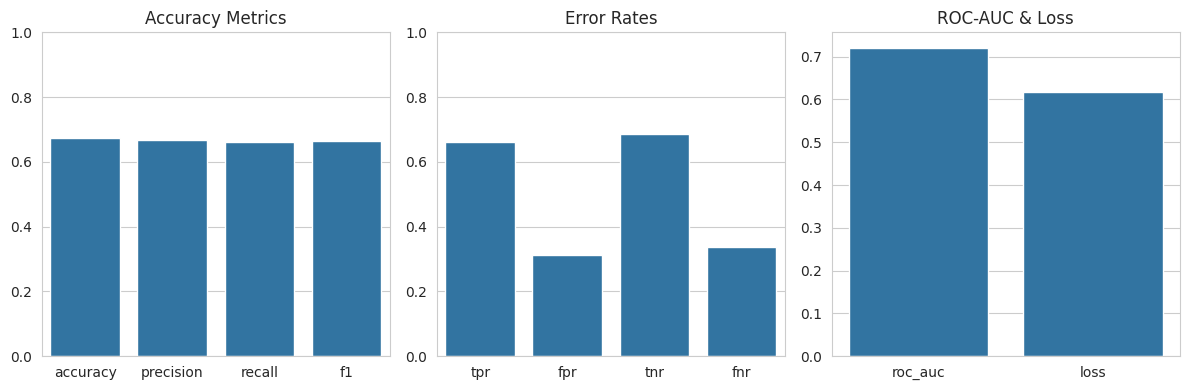

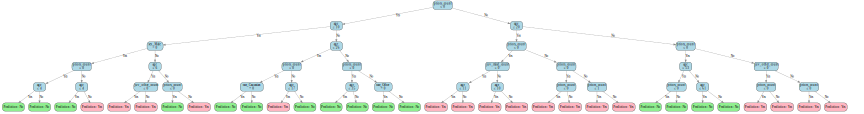


Model saved as: decision_tree_model_20250703.joblib


In [4]:
# DECISION TREE

# Set initial parameters and run hyperparameter optimization and get evaluation results
params = {'criterion': 'entropy','min_samples_split': 15,'min_samples_leaf': 8,'random_state': 42}

min_td, max_td = 2, 6
optimization_evals, best_depth, depth_analysis = optimize_depth(train_data, model_type='decision_tree', min_td=min_td, max_td=max_td, n_fold=5,
                                                                params=params, overfitting_penalty=0.3)

# Plot optimization results
opt_fig = plot_optimization_evals(optimization_evals)
plt.show()

# Train final model with best depth and evaluate final model performance
params['max_depth'] = best_depth
model_dt = train_model(train_data, model_type='decision_tree', params=params)
test_evals = test_model(model_dt, test_data)
eval_fig = plot_evals(test_evals)
plt.show()

# Display tree visualization and save model
tree_graph = tree_viz(model_dt)
display(tree_graph)

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d')
model_filename = f'decision_tree_model_{timestamp}.joblib'
dump(model_dt, model_filename)
print(f'\nModel saved as: {model_filename}')


Best depth: 6
Overall Accuracy: 67.8%
Validation Accuracy: 0.678
Overfitting Gap: 0.041


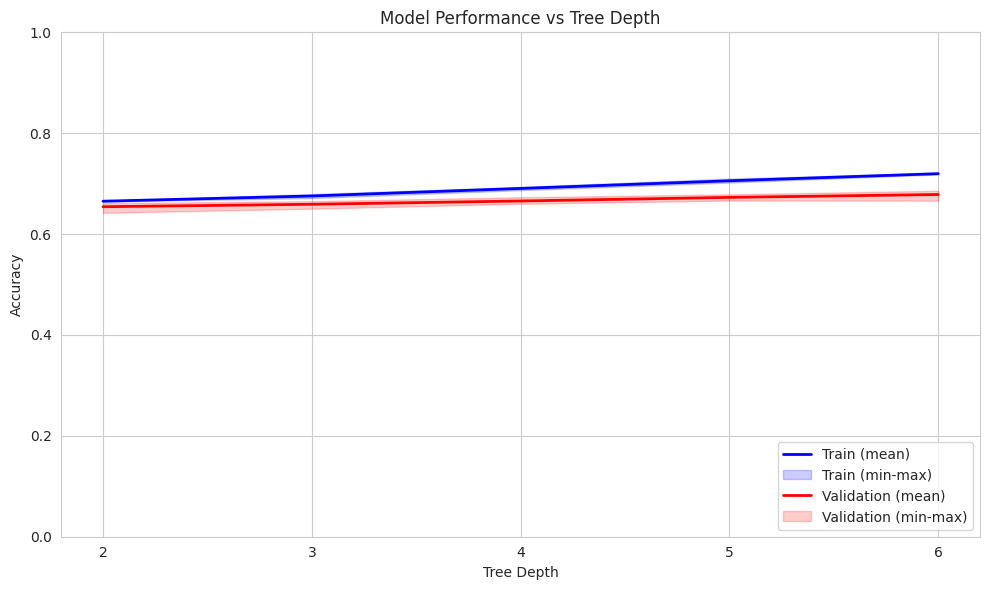

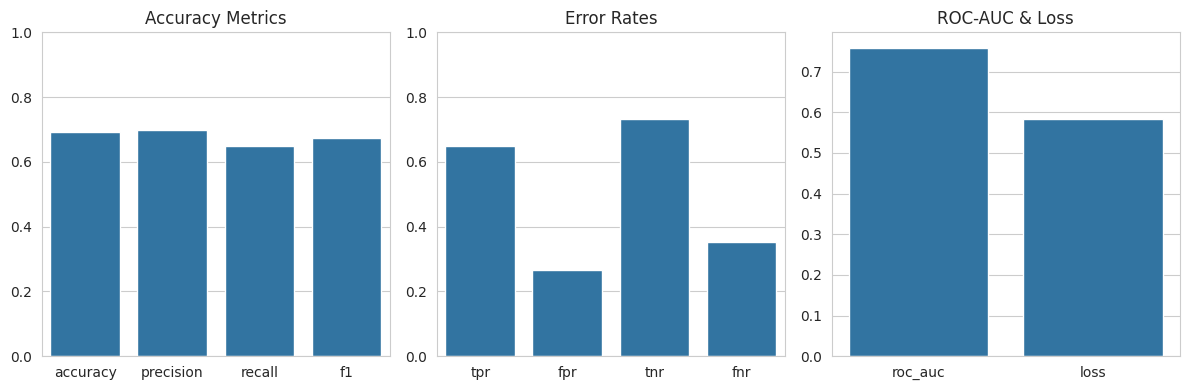


Model saved as: xgboost_model_20250703.joblib


In [5]:
# XGBOOST

# initial parameters for XGBoost
params = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8,
    'objective': 'binary:logistic', 'random_state': 42,'n_estimators': 500}

# Run hyperparameter optimization and get evaluation results
min_td, max_td = 2, 6
optimization_evals, best_depth, depth_analysis = optimize_depth(train_data, model_type='xgboost', min_td=min_td, max_td=max_td,
                                                              n_fold=5, params=params)

# Plot optimization results
opt_fig = plot_optimization_evals(optimization_evals)
plt.show()

# Train final model with best depth and evaluate final model performance
params['max_depth'] = best_depth
model_xgb = train_model(train_data, model_type='xgboost', params=params)
test_evals = test_model(model_xgb, test_data)

# Plot final model evaluation metrics
eval_fig = plot_evals(test_evals)
plt.show()

# Save the model
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d')
model_filename = f'xgboost_model_{timestamp}.joblib'
dump(model_xgb, model_filename)
print(f'\nModel saved as: {model_filename}')

Training model on full training set...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5476 - auc: 0.5636 - loss: 1.9814 - val_accuracy: 0.5404 - val_auc: 0.5779 - val_loss: 0.6995 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5065 - auc: 0.5010 - loss: 0.6962 - val_accuracy: 0.5404 - val_auc: 0.5000 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5158 - auc: 0.4949 - loss: 0.6927 - val_accuracy: 0.5404 - val_auc: 0.5000 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5139 - auc: 0.4949 - loss: 0.6929 - val_accuracy: 0.5404 - val_auc: 0.5000 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5181 - auc: 0.5030 - loss: 0.6925 - val_accuracy: 0.5404 - val_auc: 0.5000 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5225 - auc: 0.5007 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5281 - auc_1: 0.5417 - loss: 1.9886 - val_accuracy: 0.5218 - val_auc_1: 0.5000 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5225 - auc_1: 0.4939 - loss: 0.6946 - val_accuracy: 0.5218 - val_auc_1: 0.5000 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5217 - auc_1: 0.4978 - loss: 0.6923 - val_accuracy: 0.5218 - val_auc_1: 0.5000 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5241 - auc_1: 0.4893 - loss: 0.6922 - val_accuracy: 0.5218 - val_auc_1: 0.5000 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5103 - auc_1: 0.5020 - loss: 0.6930 - val_accuracy: 0.5218 - val_auc_1: 0.5000 - val_loss: 0.6922 - learning_rate: 2.0000e-04
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation Metrics:
Overall Accuracy: 52.18%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.5000
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6922

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1461
False Positives: 0
False Negatives: 1339


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 2/5
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5444 - auc: 0.5473 - loss: 1.9764 - val_accuracy: 0.5230 - val_auc: 0.5205 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5198 - auc: 0.4955 - loss: 0.6951 - val_accuracy: 0.5230 - val_auc: 0.5000 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5248 - auc: 0.5028 - loss: 0.6920 - val_accuracy: 0.5230 - val_auc: 0.5000 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5193 - auc: 0.4995 - loss: 0.6924 - val_accuracy: 0.5230 - val_auc: 0.5000 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5240 - auc: 0.5022 - loss: 0.6921 - val_accuracy: 0.5230 - val_auc: 0.5000 - val_loss: 0.6921 - learning_rate: 2.0000e-04

Training Summary:
Total epochs trained: 5
Best validation loss: 0.6921
Final train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation Metrics:
Overall Accuracy: 52.30%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.4990
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6921

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1464
False Positives: 0
False Negatives: 1335


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3/5
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5227 - auc: 0.5307 - loss: 1.9964 - val_accuracy: 0.5105 - val_auc: 0.5000 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5189 - auc: 0.4907 - loss: 0.6944 - val_accuracy: 0.5105 - val_auc: 0.5000 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5247 - auc: 0.4949 - loss: 0.6921 - val_accuracy: 0.5105 - val_auc: 0.5000 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5194 - auc: 0.4850 - loss: 0.6925 - val_accuracy: 0.5105 - val_auc: 0.5000 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5185 - auc: 0.4816 - loss: 0.6927 - val_accuracy: 0.5105 - val_auc: 0.5000 - val_loss: 0.6933 - learning_rate: 2.0000e-04
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5242 - auc: 0.49

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation Metrics:
Overall Accuracy: 51.05%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.5000
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6930

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1429
False Positives: 0
False Negatives: 1370


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4/5
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5268 - auc: 0.5435 - loss: 1.9758 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5206 - auc: 0.4939 - loss: 0.6949 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5027 - auc: 0.4929 - loss: 0.6932 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5115 - auc: 0.4956 - loss: 0.6935 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5147 - auc: 0.4950 - loss: 0.6928 - val_accuracy: 0.5338 - val_auc: 0.5000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5174 - auc: 0.4905 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation Metrics:
Overall Accuracy: 53.38%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.5001
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6909

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1494
False Positives: 0
False Negatives: 1305


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 5/5
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5204 - auc: 0.5295 - loss: 1.9954 - val_accuracy: 0.5141 - val_auc: 0.5000 - val_loss: 0.6998 - learning_rate: 0.0010
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5270 - auc: 0.4890 - loss: 0.6948 - val_accuracy: 0.5141 - val_auc: 0.5000 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5154 - auc: 0.4964 - loss: 0.6927 - val_accuracy: 0.5141 - val_auc: 0.5000 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5247 - auc: 0.4940 - loss: 0.6920 - val_accuracy: 0.5141 - val_auc: 0.5000 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5284 - auc: 0.4938 - loss: 0.6918 - val_accuracy: 0.5141 - val_auc: 0.5000 - val_loss: 0.6928 - learning_rate: 2.0000e-04

Training Summary:
Total epochs trained: 5
Best validation loss: 0.6928
Final train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Evaluation Metrics:
Overall Accuracy: 51.41%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.5391
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6928

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1439
False Positives: 0
False Negatives: 1360


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validation Summary:
Mean Accuracy: 52.06% (±0.80%)
Mean Balanced Accuracy: 50.00% (±0.00%)
Mean ROC AUC: 0.5077 (±0.0157)
Mean F1 Score: 0.0000 (±0.0000)
Mean Matthews Correlation Coefficient: 0.0000 (±0.0000)
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation Metrics:
Overall Accuracy: 51.20%
Balanced Accuracy: 50.00%
Precision: 0.00%
Recall (Sensitivity): 0.00%
Specificity: 100.00%
F1 Score: 0.0000
ROC AUC: 0.5000
Matthews Correlation Coefficient: 0.0000
Log Loss: 0.6930

Confusion Matrix Metrics:
True Positives: 0
True Negatives: 1792
False Positives: 0
False Negatives: 1708


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


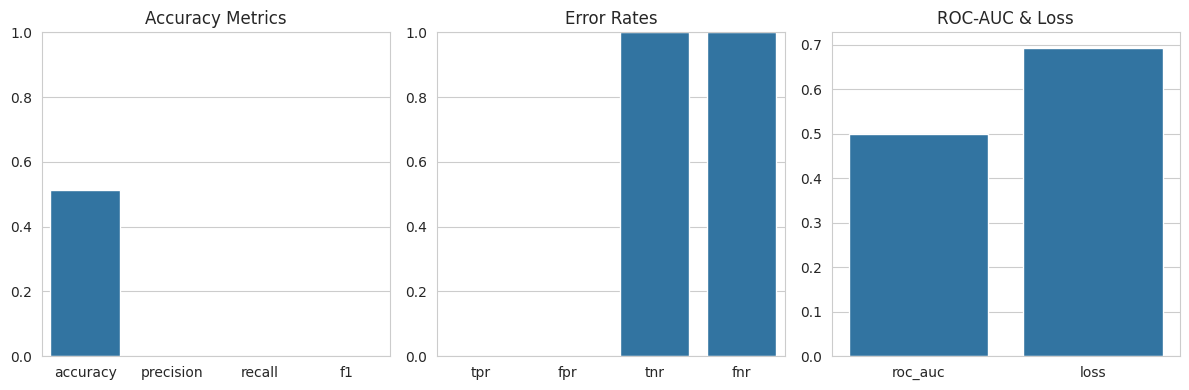

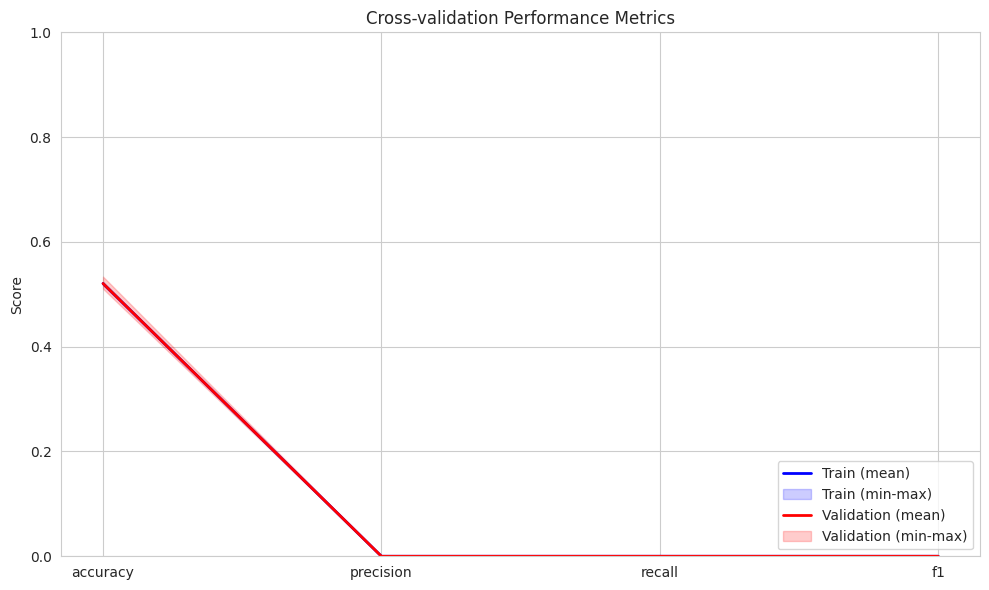


Model saved as: neural_network_model_20250703.keras


In [9]:
# NEURAL NETWORK

# Train model on full training set
print("Training model on full training set...")
final_model, history = train_neural_network(train_data)

# Run cross-validation to assess model stability
print("\nStarting 5-fold cross-validation to assess model stability...")
cv_evals = train_with_crossvalidation_nn(train_data, n_fold=5)

# Evaluate on test set
test_evals = test_model_nn(final_model, test_data)
eval_fig = plot_evals(test_evals)
plt.show()

# Plot cross-validation results
cv_fig = plot_cv_evals(cv_evals)
plt.show()

# Save the model
timestamp = datetime.now().strftime('%Y%m%d')
model_path = f'neural_network_model_{timestamp}.keras'
save_model(final_model, model_path)
print(f'\nModel saved as: {model_path}')

